In [2]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
import json
import glob
from tqdm.notebook import tqdm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from random import shuffle




In [3]:
# Load DINOv2 model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vitg14")
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

Using cache found in C:\Users\abadd/.cache\torch\hub\facebookresearch_dinov2_main


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [4]:
# Image transformation
transform_image = T.Compose([
    T.Resize(244),
    T.CenterCrop(224),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])



In [5]:
def load_image(img: str) -> torch.Tensor:
    """Load an image and return a tensor."""
    img = Image.open(img)
    return transform_image(img)[:3].unsqueeze(0)

def compute_embeddings(files: list) -> dict:
    """Compute embeddings for a list of image files."""
    all_embeddings = {}
    with torch.no_grad():
        for file in tqdm(files):
            embeddings = dinov2_vits14(load_image(file).to(device))
            all_embeddings[file] = np.array(embeddings[0].cpu().numpy()).reshape(1, -1).tolist()
    return all_embeddings



In [6]:
def train_svm(embeddings, labels):
    """Train an SVM model using GridSearchCV."""
    embedding_list = list(embeddings.values())
    y = [labels[file] for file in embeddings.keys()]
    combined = list(zip(embedding_list, y))
    shuffle(combined)
    embedding_list, y = zip(*combined)
    embedding_list = np.array(embedding_list).squeeze(1)
    
    svm = SVC(C = 10, gamma = 0.001, kernel= 'rbf')
    svm.fit(embedding_list, y)
    return svm



In [7]:
# Load and prepare binary dataset
binary_root = "C:/Tesis/DatasetBinario/train"
binary_labels = {os.path.join(binary_root, folder, file): folder for folder in os.listdir(binary_root) for file in os.listdir(os.path.join(binary_root, folder)) if file.endswith(('.jpg', '.png'))}
binary_embeddings = compute_embeddings(list(binary_labels.keys()))
binary_model = train_svm(binary_embeddings, binary_labels)



  0%|          | 0/20959 [00:00<?, ?it/s]

In [8]:
# Load and prepare 4-class dataset
multi_root = "C:/Thesis/Dataset4Classes2/train"
multi_labels = {os.path.join(multi_root, folder, file): folder for folder in os.listdir(multi_root) for file in os.listdir(os.path.join(multi_root, folder)) if file.endswith(('.jpg', '.png'))}
multi_embeddings = compute_embeddings(list(multi_labels.keys()))
multi_model = train_svm(multi_embeddings, multi_labels)



  0%|          | 0/45388 [00:00<?, ?it/s]

In [9]:
# Evaluation
valid_root = "C:/Thesis/Dataset4Classes2/test"
valid_labels = {os.path.join(valid_root, folder, file): folder for folder in os.listdir(valid_root) for file in os.listdir(os.path.join(valid_root, folder)) if file.endswith(('.jpg', '.png'))}
valid_embeddings = compute_embeddings(list(valid_labels.keys()))
y_true = [valid_labels[file] for file in valid_labels.keys()]



  0%|          | 0/1150 [00:00<?, ?it/s]

In [13]:
def predict_combined(image_path):
    """Predicts using binary model first, then multi-class if not melanoma."""
    embedding = np.array(valid_embeddings[image_path]).reshape(1, -1)
    binary_pred = binary_model.predict(embedding)[0]
    print(binary_pred)
    if binary_pred == "Melanoma":
        return "mel"
    return multi_model.predict(embedding)[0]

y_pred = [predict_combined(file) for file in valid_labels.keys()]
print("Accuracy:", accuracy_score(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred)) 

No Melanoma
No Melanoma
Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
Melanoma
No Melanoma
Melanoma
No Melanoma
Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
No Melanoma
Melanom

In [14]:
print("Classification Report:\n", classification_report(y_true, y_pred)) 

Classification Report:
               precision    recall  f1-score   support

         bcc       0.89      0.80      0.85       300
         mel       0.75      1.00      0.85       300
      others       0.81      0.80      0.80       400
         scc       0.95      0.55      0.70       150

    accuracy                           0.82      1150
   macro avg       0.85      0.79      0.80      1150
weighted avg       0.83      0.82      0.81      1150



In [24]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

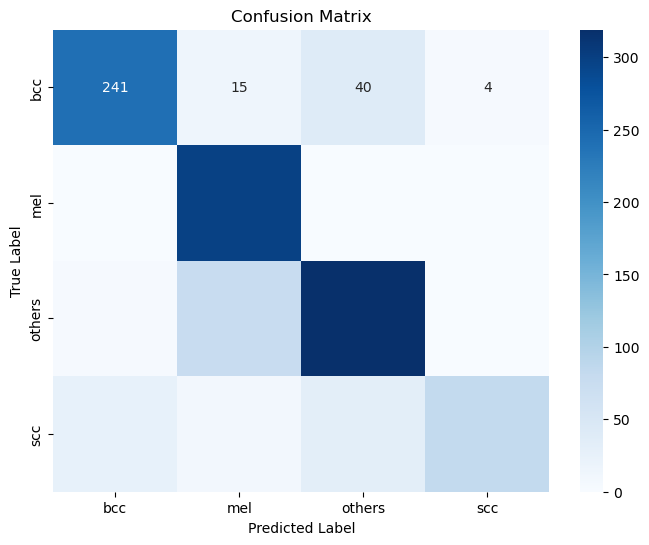

In [17]:
# Print confusion matrix
labels = sorted(list(set(y_true) | set(y_pred)))
cm = confusion_matrix(y_true, y_pred, labels=labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

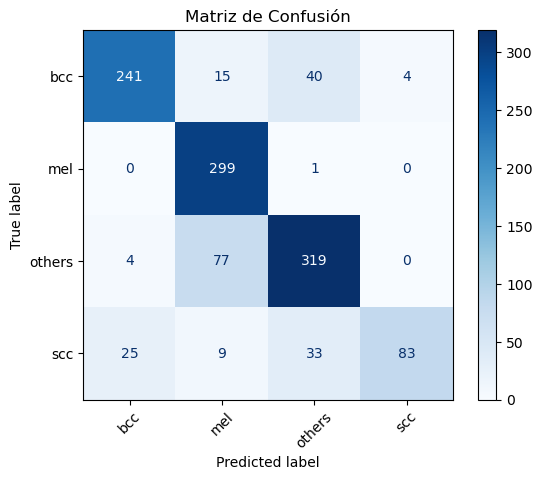

In [21]:
# Matriz de Confusión
labels = sorted(list(set(y_true) | set(y_pred)))
cm = confusion_matrix(y_true, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Matriz de Confusión")
plt.show()


In [27]:
# Precision, Sensibilidad y F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=labels)
print("Métricas por clase:")
for i, label in enumerate(labels):
    print(f"Clase {label}: Precisión={precision[i]:.3f}, Sensibilidad={recall[i]:.3f}, F1-score={f1[i]:.3f}")
    
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", f"{accuracy:.3f}")



Métricas por clase:
Clase bcc: Precisión=0.893, Sensibilidad=0.803, F1-score=0.846
Clase mel: Precisión=0.748, Sensibilidad=0.997, F1-score=0.854
Clase others: Precisión=0.812, Sensibilidad=0.797, F1-score=0.805
Clase scc: Precisión=0.954, Sensibilidad=0.553, F1-score=0.700
Accuracy: 0.819
